# Testing tiling and untiling
This notebook tests tiling and untiling large images

In [3]:
import os
import numpy as np

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
import deepcell_toolbox

In [4]:
import scipy.signal

def tile_image(image, model_input_shape=(512, 512), stride_ratio=0.75): 
    
    print('tile_image: model_input_shape = ', model_input_shape, ', stride_ratio = ', stride_ratio)
    
    """
    Tile large image into many overlapping tiles of size "model_input_shape".
    Args:
        image (numpy.array): The image to tile, must be rank 4.
        model_input_shape (tuple): The input size of the model.
        stride_ratio (float): The stride expressed as a fraction of the tile size
    Returns:
        tuple(numpy.array, dict): An tuple consisting of an array of tiled
            images and a dictionary of tiling details (for use in un-tiling).
    Raises:
        ValueError: image is not rank 4.
    """
    if image.ndim != 4:
        raise ValueError('Expected image of rank 2, 3 or 4, got {}'.format(
            image.ndim))
        
    if stride_ratio < 0.5:
        raise ValueError('Stride ratio should be greater than 0.5')

    image_size_x, image_size_y = image.shape[1:3]
    tile_size_x = model_input_shape[0]
    tile_size_y = model_input_shape[1]

    ceil = lambda x: int(np.ceil(x))
    round_to_even = lambda x: int(np.ceil(x / 2.0) * 2)
    
    stride_x = round_to_even(stride_ratio * tile_size_x)
    stride_y = round_to_even(stride_ratio * tile_size_y)

    rep_number_x = ceil((image_size_x - tile_size_x) / stride_x + 1)
    rep_number_y = ceil((image_size_y - tile_size_y) / stride_y + 1)
    new_batch_size = image.shape[0] * rep_number_x * rep_number_y

    tiles_shape = (new_batch_size, tile_size_x, tile_size_y, image.shape[3])
    tiles = np.zeros(tiles_shape, dtype=image.dtype)

    counter = 0
    batches = []
    x_starts = []
    x_ends = []
    y_starts = []
    y_ends = []
    overlaps_x = []
    overlaps_y = []

    for b in range(image.shape[0]):
        for i in range(rep_number_x):
            for j in range(rep_number_y):
                x_axis = 1
                y_axis = 2
                
                # Compute the start and end for each tile
                if i != rep_number_x - 1:  # not the last one
                    x_start, x_end = i * stride_x, i * stride_x + tile_size_x
                else:
                    x_start, x_end = image.shape[x_axis] - tile_size_x, image.shape[x_axis]

                if j != rep_number_y - 1:  # not the last one
                    y_start, y_end = j * stride_y, j * stride_y + tile_size_y
                else:
                    y_start, y_end = image.shape[y_axis] - tile_size_y, image.shape[y_axis]

                # Compute the overlaps for each tile
                if i == 0:
                    overlap_x = (0, tile_size_x - stride_x)
                elif i == rep_number_x - 2:
                    overlap_x = (tile_size_x - stride_x,  tile_size_x - image.shape[x_axis] + x_end)
                elif i == rep_number_x - 1:
                    overlap_x = ((i-1)*stride_x + tile_size_x - x_start, 0)
                else:
                    overlap_x = (tile_size_x - stride_x, tile_size_x - stride_x)
                    
                if j == 0:
                    overlap_y = (0, tile_size_y - stride_y)
                elif j == rep_number_y - 2:
                    overlap_y = (tile_size_y - stride_y, tile_size_y - image.shape[y_axis] + y_end)
                elif j == rep_number_y - 1:
                    overlap_y = ((j-1)*stride_y + tile_size_y - y_start, 0)
                else:
                    overlap_y = (tile_size_y - stride_y, tile_size_y - stride_y)
                
                tiles[counter] = image[b, x_start:x_end, y_start:y_end, :]
                batches.append(b)
                x_starts.append(x_start)
                x_ends.append(x_end)
                y_starts.append(y_start)
                y_ends.append(y_end)
                overlaps_x.append(overlap_x)
                overlaps_y.append(overlap_y)
                counter += 1

    tiles_info = {}
    tiles_info['batches'] = batches
    tiles_info['x_starts'] = x_starts
    tiles_info['x_ends'] = x_ends
    tiles_info['y_starts'] = y_starts
    tiles_info['y_ends'] = y_ends
    tiles_info['overlaps_x'] = overlaps_x
    tiles_info['overlaps_y'] = overlaps_y
    tiles_info['stride_x'] = stride_x
    tiles_info['stride_y'] = stride_y
    tiles_info['tile_size_x'] = tile_size_x
    tiles_info['tile_size_y'] = tile_size_y
    tiles_info['stride_ratio'] = stride_ratio
    tiles_info['image_shape'] = image.shape
    tiles_info['dtype'] = image.dtype
    
    return tiles, tiles_info

def spline_window(window_size, overlap_left, overlap_right, power=2):
    """
    Squared spline (power=2) window function:
    https://www.wolframalpha.com/input/?i=y%3Dx**2,+y%3D-(x-2)**2+%2B2,+y%3D(x-4)**2,+from+y+%3D+0+to+2
    """
    
    def _spline_window(w_size):
        intersection = int(w_size/4)
        wind_outer = (abs(2*(scipy.signal.triang(w_size))) ** power)/2
        wind_outer[intersection:-intersection] = 0

        wind_inner = 1 - (abs(2*(scipy.signal.triang(w_size) - 1)) ** power)/2
        wind_inner[:intersection] = 0
        wind_inner[-intersection:] = 0

        wind = wind_inner + wind_outer
        wind = wind / np.amax(wind)
        return wind
        
    # Create the window for the left overlap
    if overlap_left > 0:
        window_size_l = 2*overlap_left
        l_spline = _spline_window(window_size_l)[0:overlap_left]
        
    # Create the window for the right overlap
    if overlap_right > 0:
        window_size_r = 2*overlap_right
        r_spline = _spline_window(window_size_r)[overlap_right:]
        
    # Put the two together
    window = np.ones((window_size,))
    if overlap_left > 0:
        window[0:overlap_left] = l_spline
    if overlap_right > 0:
        window[-overlap_right:] = r_spline
    
    return window


def window_2D(window_size, overlap_x = (32,32), overlap_y = (32,32), power=2):
    """
    Make a 1D window function, then infer and return a 2D window function.
    Done with an augmentation, and self multiplication with its transpose.
    Could be generalized to more dimensions.
    """
    window_x = spline_window(window_size[0], overlap_x[0], overlap_x[1], power=power)
    window_y = spline_window(window_size[1], overlap_y[0], overlap_y[1], power=power)
    
    window_x = np.expand_dims(np.expand_dims(window_x, -1), -1)
    window_y = np.expand_dims(np.expand_dims(window_y, -1), -1)
    
    window = window_x * window_y.transpose(1, 0, 2)
    return window


def untile_image(tiles, tiles_info, power=2):
    stride_ratio = tiles_info['stride_ratio']
    if stride_ratio < 0.5:
        raise ValueError('stride_ratio must be between 0.5 and 1')
        
    image_shape = tiles_info['image_shape']   
    batches = tiles_info['batches']
    x_starts = tiles_info['x_starts']
    x_ends = tiles_info['x_ends']
    y_starts = tiles_info['y_starts']
    y_ends = tiles_info['y_ends']
    overlaps_x = tiles_info['overlaps_x']
    overlaps_y = tiles_info['overlaps_y']
    stride_x = tiles_info['stride_x']
    stride_y = tiles_info['stride_y']
    tile_size_x = tiles_info['tile_size_x']
    tile_size_y = tiles_info['tile_size_y']
    stride_ratio = tiles_info['stride_ratio']
    
    image_shape = [image_shape[0], image_shape[1], image_shape[2], tiles.shape[-1]]
    window_size = (tile_size_x, tile_size_y)
    image = np.zeros(image_shape, dtype=np.float)
    
    n_tiles = tiles.shape[0]

    for tile, batch, x_start, x_end, y_start, y_end, overlap_x, overlap_y in zip(
            tiles, batches, x_starts, x_ends, y_starts, y_ends, overlaps_x, overlaps_y):

        window = window_2D(window_size, overlap_x=overlap_x, overlap_y=overlap_y, power=power)
        image[batch, x_start:x_end, y_start:y_end, :] += tile * window
        
    image = image.astype(tiles.dtype)

    return image

## Test spline window

1.0


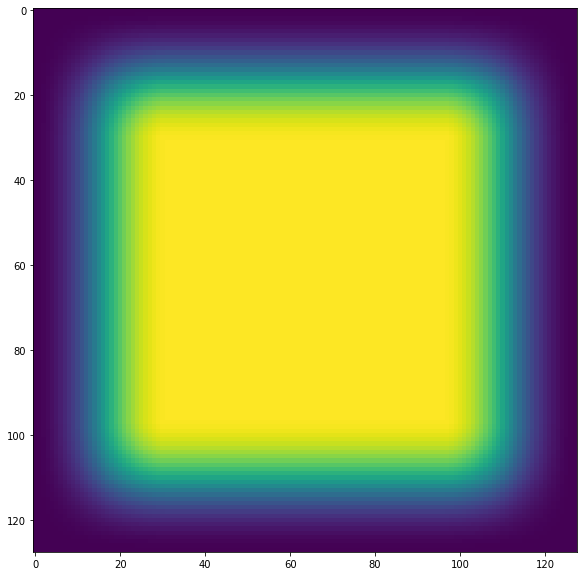

In [5]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(1,1, figsize=(10,10))
window = window_2D((128,128), overlap_x=(32,32), overlap_y=(32,32), power=2)
print(np.amax(window))
axes.imshow(window[...,0])

## Test tiling on an image

In [6]:
import imageio

# Load data
nuclear_file = '/data/nuclear_gif.gif'
im = imageio.get_reader(nuclear_file)

images = []

for frame in im:
    images.append(frame)
images = np.stack(images, axis=0)
images = np.expand_dims(images, axis=-1)

print(images.shape)

FileNotFoundError: No such file: '/data/nuclear_gif.gif'

In [5]:
tiles, tiles_info = tile_image(images, model_input_shape=(128, 128), stride_ratio=0.95)

tile_image: model_input_shape =  (128, 128) , stride_ratio =  0.95


In [6]:
untiled_images = untile_image(tiles, tiles_info, power=3)

In [7]:
print(images.shape, untiled_images.shape)

(71, 512, 512, 1) (71, 512, 512, 1)


0


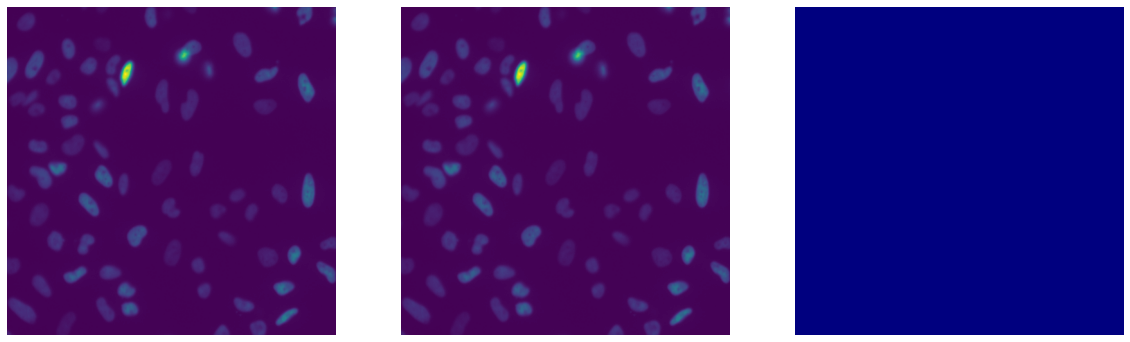

In [8]:
from matplotlib import pyplot as plt
i = 70
fig, axes = plt.subplots(1,3, figsize=(20,20))
axes = axes.flatten()
for ax in axes:
    ax.set_axis_off()
axes[0].imshow(images[i,...,0])
axes[1].imshow(untiled_images[i,:,:,0])
axes[2].imshow((images-untiled_images)[i,:,:,0], cmap='jet')
print(np.amax((images-untiled_images)[i,...,0]))